# Skyline Hospital Time Series Forecasting with XGBoost Solution 2

### 1. Import the necessary libraries and modules

In [51]:
# Data manipulation
import pandas as pd
import numpy as np
import pyarrow

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Plot aesthetics
color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb  # ML algorithm for forecasting
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Error metrics

### 2. Load the dataset

In [2]:
df = pd.read_csv("data/skyline_hospital_bill_charge_report.csv")
df

Open Date  Bill No.      Charge Head Doctor Code  Qty
0       2020-05-18  BL427653  OP Consultation     DOC0114    1
1       2020-05-18  BL427654  OP Consultation     DOC0114    1
2       2020-05-18  BL427655  OP Consultation     DOC0207    1
3       2020-05-18  BL427656  OP Consultation     DOC0114    1
4       2020-05-18  BL427657  OP Consultation     DOC0114    1
...            ...       ...              ...         ...  ...
126152  2022-12-31  BL678528  OP Consultation     DOC0553    1
126153  2022-12-31  BL678529  OP Consultation     DOC0207    1
126154  2022-12-31  BL678530  OP Consultation     DOC0114    1
126155  2022-12-31  BL678531  OP Consultation     DOC0114    1
126156  2022-12-31  BL678535  OP Consultation     DOC0207    1

[126157 rows x 5 columns]

In [3]:
df = df[['Open Date', 'Qty']]
df = df.rename(columns={'Open Date': 'Date', 'Qty': 'Patients'})
df

Date  Patients
0       2020-05-18         1
1       2020-05-18         1
2       2020-05-18         1
3       2020-05-18         1
4       2020-05-18         1
...            ...       ...
126152  2022-12-31         1
126153  2022-12-31         1
126154  2022-12-31         1
126155  2022-12-31         1
126156  2022-12-31         1

[126157 rows x 2 columns]

In [4]:
df = df.groupby(by='Date', as_index=False)['Patients'].sum()

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index(keys='Date')
df

Patients
Date                
2020-05-18        67
2020-05-19        75
2020-05-20        74
2020-05-21        55
2020-05-22        62
...              ...
2022-12-27       114
2022-12-28       156
2022-12-29       105
2022-12-30        24
2022-12-31        23

[856 rows x 1 columns]

In [8]:
new_index = pd.date_range(start='2020-05-18', end='2022-12-31', freq='D')
df = df.reindex(new_index)
df

Patients
2020-05-18      67.0
2020-05-19      75.0
2020-05-20      74.0
2020-05-21      55.0
2020-05-22      62.0
...              ...
2022-12-27     114.0
2022-12-28     156.0
2022-12-29     105.0
2022-12-30      24.0
2022-12-31      23.0

[958 rows x 1 columns]

### 3. Visualize the data

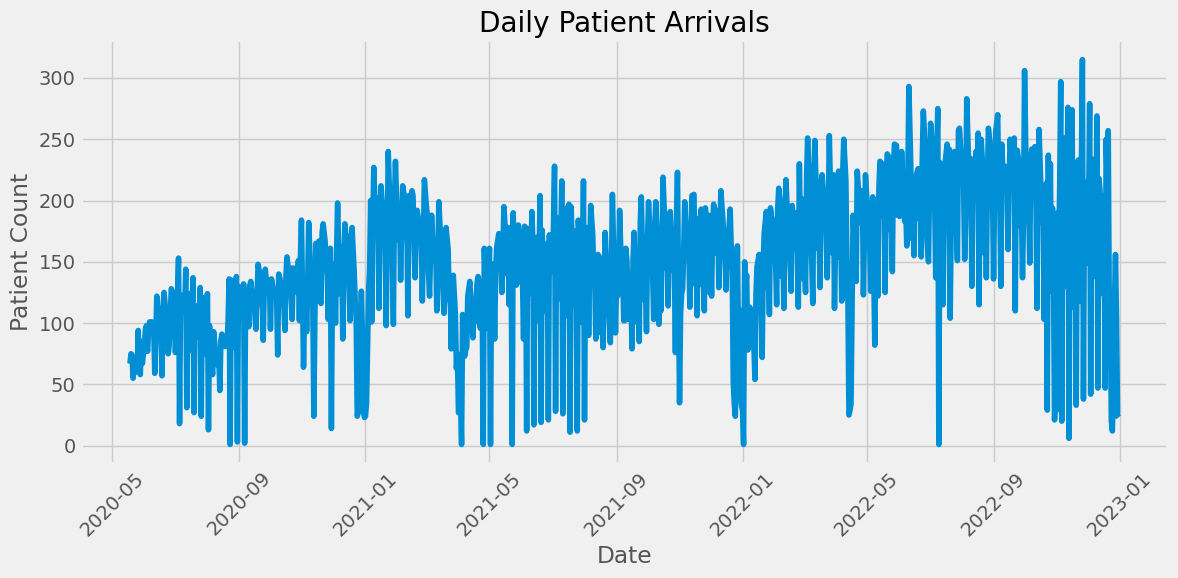

In [9]:
# Visualize the time series data
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=df.index, y='Patients', data=df, ax=ax)

# Set plot title and axis labels
ax.set_title('Daily Patient Arrivals')
ax.set_xlabel('Date')
ax.set_ylabel('Patient Count')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [10]:
missing_vals = df[df.isnull().any(axis=1)]
print(missing_vals)

            Patients
2020-05-24       NaN
2020-05-31       NaN
2020-06-07       NaN
2020-06-14       NaN
2020-06-21       NaN
...              ...
2022-09-18       NaN
2022-09-25       NaN
2022-10-02       NaN
2022-10-09       NaN
2022-10-16       NaN

[102 rows x 1 columns]


In [11]:
df = df.interpolate(method='linear')

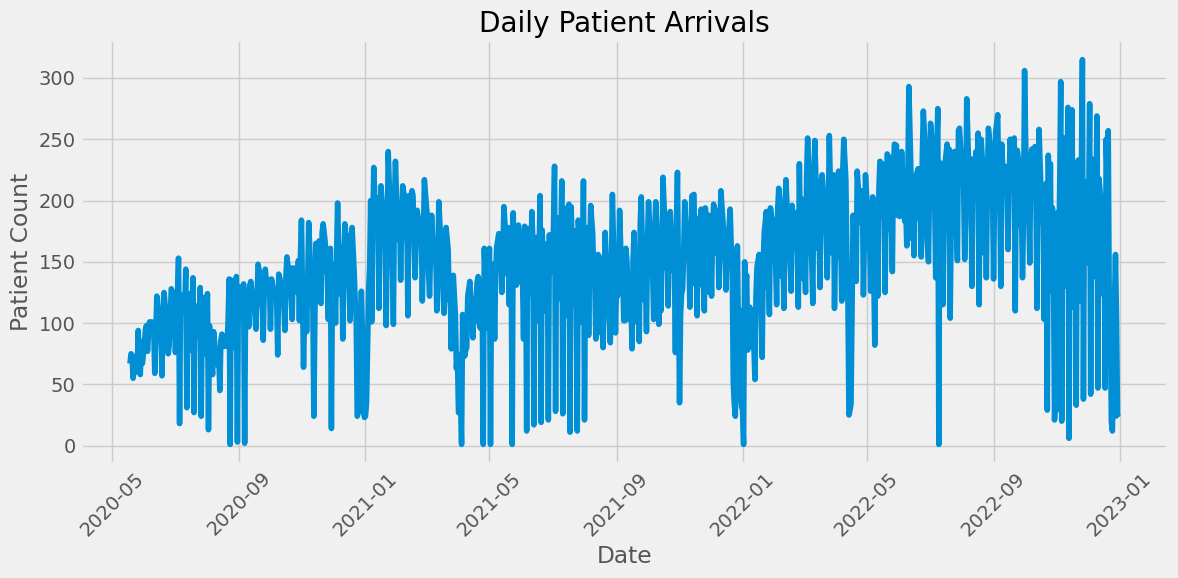

In [12]:
# Visualize the time series data
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=df.index, y='Patients', data=df, ax=ax)

# Set plot title and axis labels
ax.set_title('Daily Patient Arrivals')
ax.set_xlabel('Date')
ax.set_ylabel('Patient Count')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

## Time series decomposition

In [13]:
from statsmodels.tsa.seasonal import STL

In [14]:
patients_series = df['Patients']

In [15]:
# Perform STL decomposition
stl = STL(patients_series, seasonal=7)
result = stl.fit()

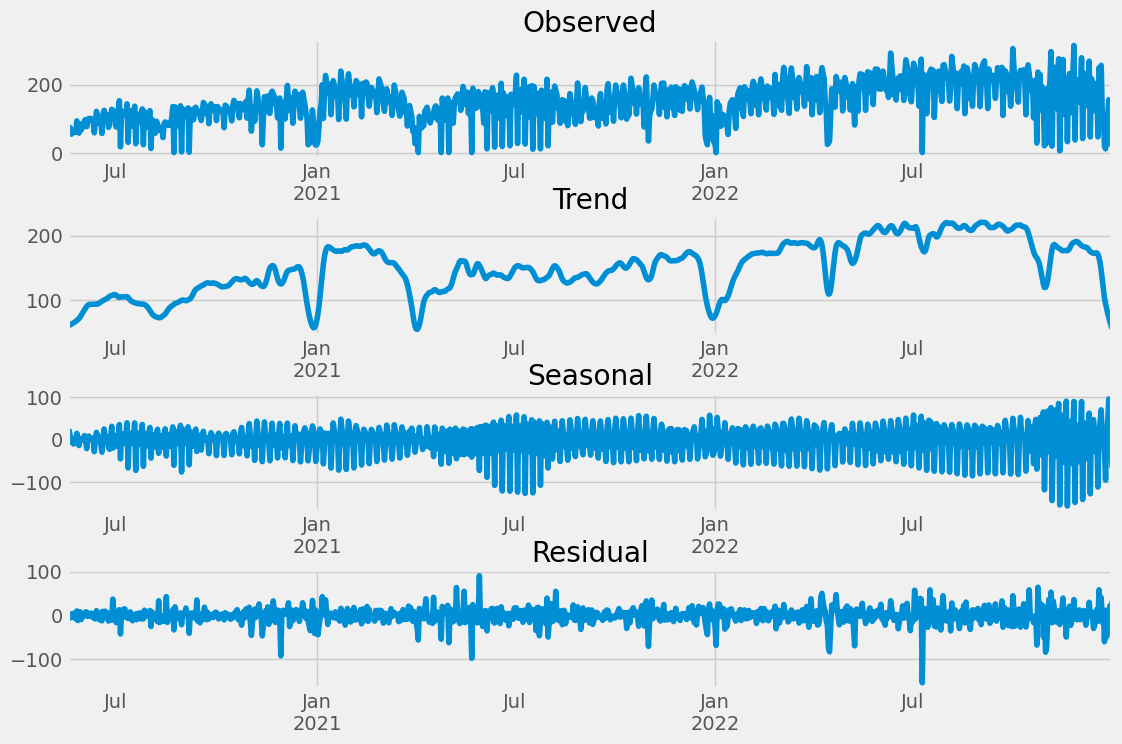

In [16]:
# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residual')

plt.show()

## Outlier analysis, detection and handling

In [19]:
## Calculate the IQR and bounds
Q1 = patients_series.quantile(0.25)
Q3 = patients_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 0.1 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Lower Bound: {lower_bound}')
print(f'Upper Bound: {upper_bound}')

Lower Bound: 106.2
Upper Bound: 309.0


In [20]:
def custom_winsorize(x):
    if x < lower_bound:
        return lower_bound
    elif x > upper_bound:
        return upper_bound
    else:
        return x

cleaned_series = patients_series.copy()
cleaned_series = cleaned_series.apply(custom_winsorize)
df['Patients'] = cleaned_series.copy()

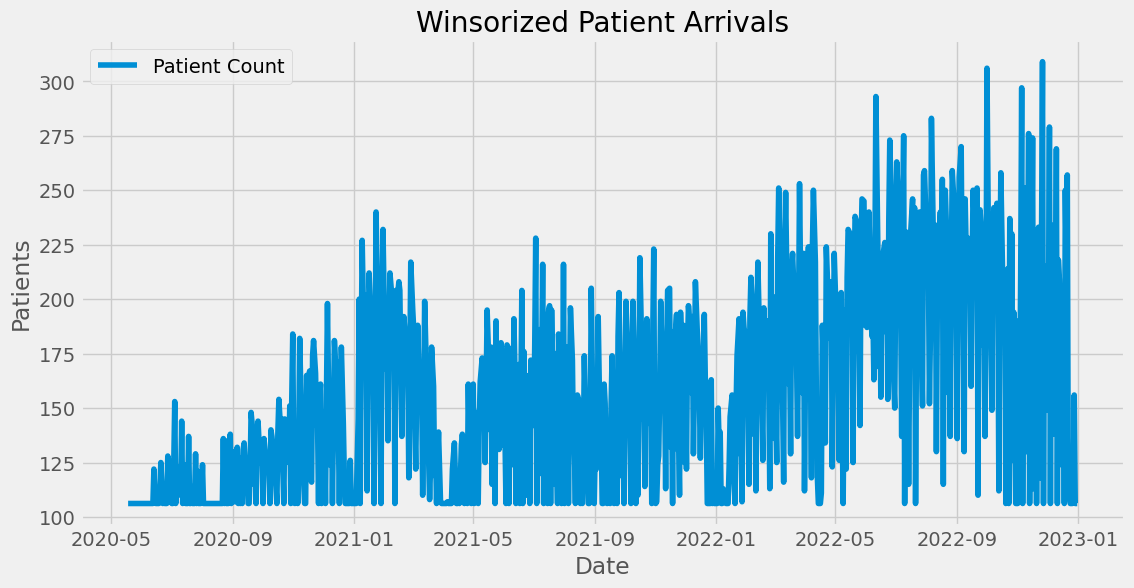

In [21]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the winsorized patient arrivals data
ax.plot(df.index, df['Patients'], label='Patient Count')

# Set the title and labels for the plot
ax.set_title('Winsorized Patient Arrivals')
ax.set_xlabel('Date')
ax.set_ylabel('Patients')

# Show the legend
ax.legend()

# Display the plot
plt.show()

## Feature engineering

In [26]:
def create_features(df, label=None):
    """
    Create time series features from the datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    
    window_size = 7  # 7-day rolling window

    # Rolling minimum
    df['rolling_min'] = df['Patients'].rolling(window=window_size).min()

    # Rolling maximum
    df['rolling_max'] = df['Patients'].rolling(window=window_size).max()

    # Rolling sum
    df['rolling_sum'] = df['Patients'].rolling(window=window_size).sum()

    # Rolling mean
    df['rolling_mean'] = df['Patients'].rolling(window=window_size).mean()

    # Rolling median
    df['rolling_median'] = df['Patients'].rolling(window=window_size).median()

    # Rolling standard deviation
    df['rolling_std'] = df['Patients'].rolling(window=window_size).std()

    # Rolling quantile (25th percentile)
    quantile_25 = 0.25
    df['rolling_quantile_25'] = df['Patients'].rolling(window=window_size).quantile(quantile_25)
    
    # Rolling quantile(50th percentile)
    quantile_50 = 0.50
    df['rolling_quantile_50'] = df['Patients'].rolling(window=window_size).quantile(quantile_50)

    # Rolling quantile (75th percentile)
    quantile_75 = 0.75
    df['rolling_quantile_75'] = df['Patients'].rolling(window=window_size).quantile(quantile_75)

    return df

df = create_features(df)

In [27]:
df.dtypes

Patients                      float64
date                   datetime64[ns]
day_of_week                     int32
month                           int32
day_of_year                     int32
rolling_min                   float64
rolling_max                   float64
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_50           float64
rolling_quantile_75           float64
dtype: object

In [28]:
df.head()

Patients       date  day_of_week  month  day_of_year  rolling_min  \
2020-05-18     106.2 2020-05-18            0      5          139          NaN   
2020-05-19     106.2 2020-05-19            1      5          140          NaN   
2020-05-20     106.2 2020-05-20            2      5          141          NaN   
2020-05-21     106.2 2020-05-21            3      5          142          NaN   
2020-05-22     106.2 2020-05-22            4      5          143          NaN   

            rolling_max  rolling_sum  rolling_mean  rolling_median  \
2020-05-18          NaN          NaN           NaN             NaN   
2020-05-19          NaN          NaN           NaN             NaN   
2020-05-20          NaN          NaN           NaN             NaN   
2020-05-21          NaN          NaN           NaN             NaN   
2020-05-22          NaN          NaN           NaN             NaN   

            rolling_std  rolling_quantile_25  rolling_quantile_50  \
2020-05-18          NaN                  NaN                  NaN   
2020-05-19          NaN                  NaN                  NaN   
2020-05-20          NaN                  NaN                  NaN   
2020-05-21          NaN                  NaN                  NaN   
2020-05-22          NaN                  NaN                  NaN   

            rolling_quantile_75  
2020-05-18                  NaN  
2020-05-19                  NaN  
2020-05-20                  NaN  
2020-05-21                  NaN  
2020-05-22                  NaN

## Time series cross-validation

In [29]:
from sklearn.model_selection import TimeSeriesSplit

In [30]:
tss = TimeSeriesSplit(n_splits=8, test_size=119, gap=1)
df = df.sort_index()

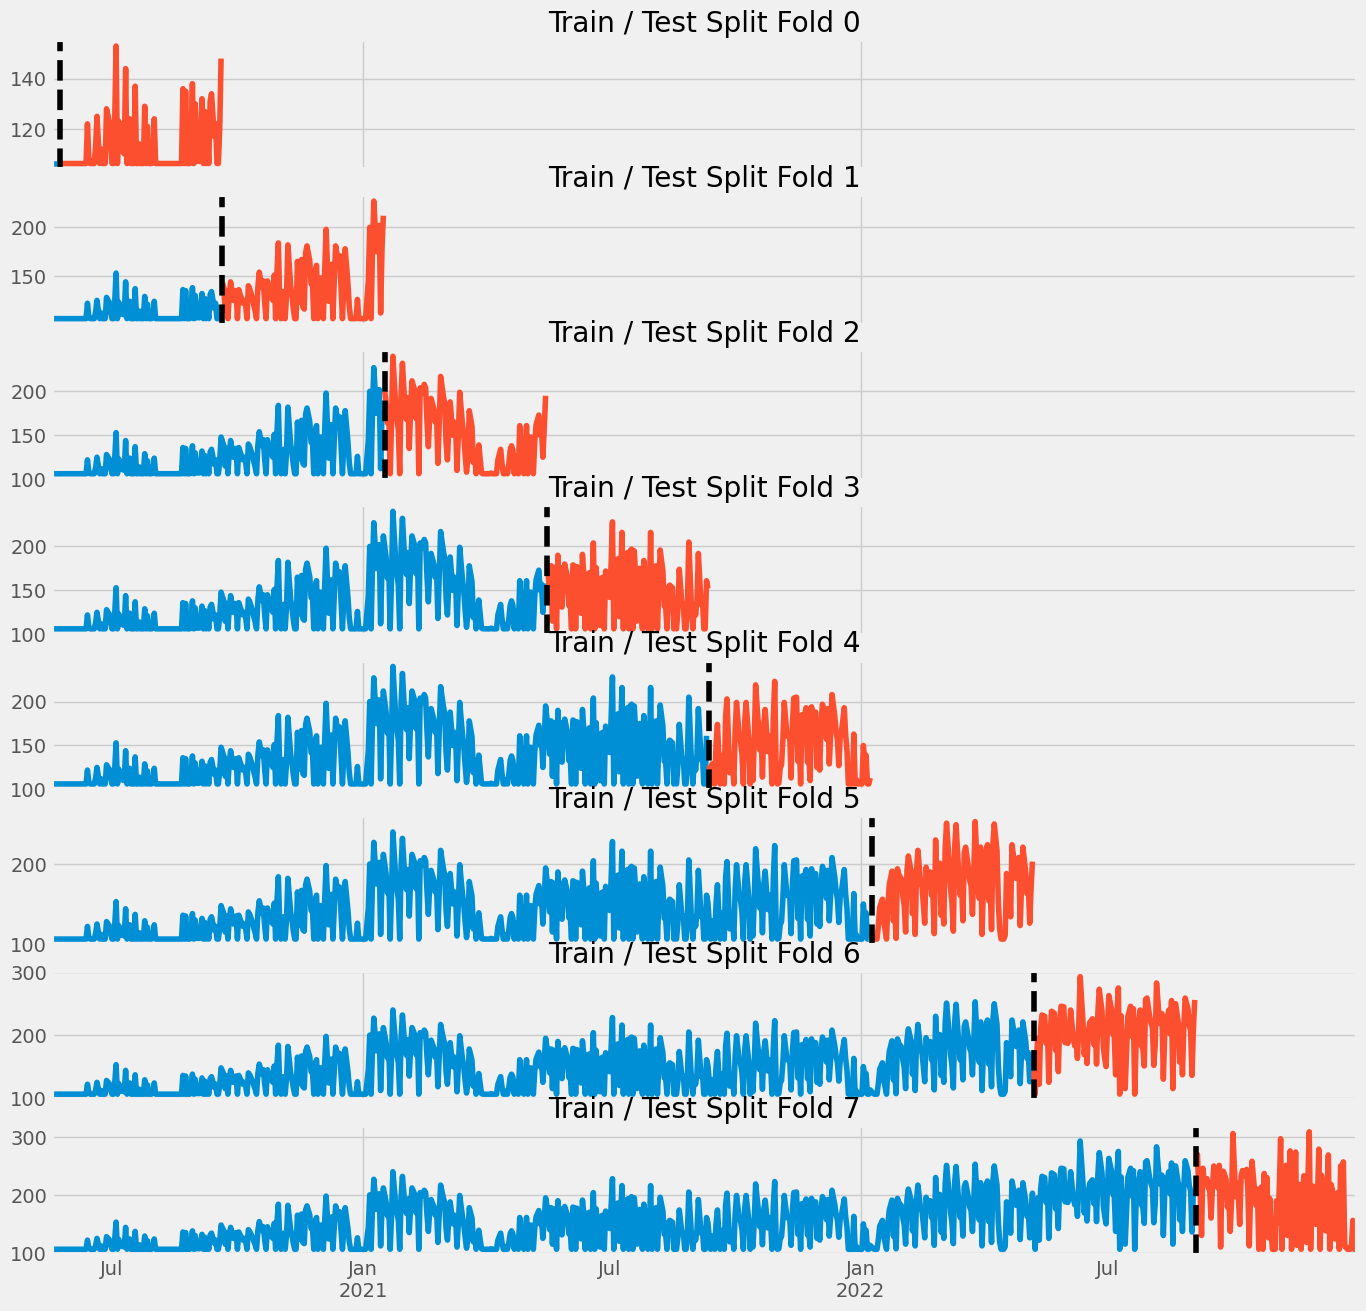

In [31]:
fig, axs = plt.subplots(8, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    train['Patients'].plot(ax=axs[fold],
                           label='Training Set',
                           title=f'Train / Test Split Fold {fold}')
    test['Patients'].plot(ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

## Forecasting horizon

## Lag features

In [32]:
def add_lags(df):
    target_map = df['Patients'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('180 days')).map(target_map)
    return df

df = add_lags(df)

This Python code defines a function called add_lags that takes a DataFrame df as input and adds three new columns to the DataFrame representing lag features. Here's a step-by-step explanation of the code:

`target_map = df['Patients'].to_dict()`: This line creates a dictionary called target_map from the 'Patients' column of the input DataFrame df. The keys of the dictionary are the DataFrame index values (dates), and the values are the corresponding patient counts.

`df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)`: This line calculates the 30-day lag feature. It subtracts 30 days from the DataFrame index (which are dates) using the pd.Timedelta function. Then, it maps the resulting dates to the patient counts using the target_map dictionary. The resulting lag feature is added as a new column named 'lag1' in the DataFrame.

`df['lag2'] = (df.index - pd.Timedelta('90 days')).map(target_map)`: This line calculates the 90-day lag feature, similar to the 30-day lag feature calculation. It subtracts 90 days from the DataFrame index and maps the resulting dates to the patient counts using the target_map dictionary. The resulting lag feature is added as a new column named 'lag2' in the DataFrame.

`df['lag3'] = (df.index - pd.Timedelta('180 days')).map(target_map)`: This line calculates the 180-day lag feature, similar to the previous lag feature calculations. It subtracts 180 days from the DataFrame index and maps the resulting dates to the patient counts using the target_map dictionary. The resulting lag feature is added as a new column named 'lag3' in the DataFrame.

`return df:` The function returns the modified DataFrame with the added lag features.

In summary, the `add_lags` function takes a DataFrame with a 'Patients' column and adds three new lag features based on 30-day, 90-day, and 180-day lags, which may help capture relevant patterns or seasonality in the patient arrivals data for time series modeling.

In [33]:
df.head()

Patients       date  day_of_week  month  day_of_year  rolling_min  \
2020-05-18     106.2 2020-05-18            0      5          139          NaN   
2020-05-19     106.2 2020-05-19            1      5          140          NaN   
2020-05-20     106.2 2020-05-20            2      5          141          NaN   
2020-05-21     106.2 2020-05-21            3      5          142          NaN   
2020-05-22     106.2 2020-05-22            4      5          143          NaN   

            rolling_max  rolling_sum  rolling_mean  rolling_median  \
2020-05-18          NaN          NaN           NaN             NaN   
2020-05-19          NaN          NaN           NaN             NaN   
2020-05-20          NaN          NaN           NaN             NaN   
2020-05-21          NaN          NaN           NaN             NaN   
2020-05-22          NaN          NaN           NaN             NaN   

            rolling_std  rolling_quantile_25  rolling_quantile_50  \
2020-05-18          NaN                  NaN                  NaN   
2020-05-19          NaN                  NaN                  NaN   
2020-05-20          NaN                  NaN                  NaN   
2020-05-21          NaN                  NaN                  NaN   
2020-05-22          NaN                  NaN                  NaN   

            rolling_quantile_75  lag1  lag2  lag3  
2020-05-18                  NaN   NaN   NaN   NaN  
2020-05-19                  NaN   NaN   NaN   NaN  
2020-05-20                  NaN   NaN   NaN   NaN  
2020-05-21                  NaN   NaN   NaN   NaN  
2020-05-22                  NaN   NaN   NaN   NaN

## Train using cross-validation

In [34]:
# Define the error metrics

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [35]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=8, test_size=119, gap=1)
df = df.sort_index()

fold = 0
preds = []

rmse_scores = []
mape_scores = []
smape_scores = []

# Initialize an empty DataFrame to store actual and predicted values
actual_vs_pred_df = pd.DataFrame()

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['day_of_year', 'day_of_week', 'month', 'rolling_min', 'rolling_max',
                'rolling_sum', 'rolling_quantile_25', 'rolling_quantile_50', 
                'rolling_quantile_75', 'rolling_mean', 'rolling_median', 
                'rolling_std', 'lag1', 'lag2', 'lag3']

    TARGET = 'Patients'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=900, 
                           early_stopping_rounds=50, 
                           tree_method='hist',
                           objective='reg:squarederror', 
                           max_depth=3, 
                           min_child_weight=3, 
                           gamma=0, 
                           learning_rate=0.01, 
                           colsample_bytree=0.9, 
                           subsample=0.7,
                           reg_lambda=0)
    
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
    
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    smape_scores.append(smape)
    
    # Store actual and predicted values along with their datetime index in the DataFrame
    temp_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred}, index=df.iloc[val_index].index)
    actual_vs_pred_df = pd.concat([actual_vs_pred_df, temp_df])

[0]	validation_0-rmse:104.64300	validation_1-rmse:111.40761
[100]	validation_0-rmse:39.08043	validation_1-rmse:46.54263
[200]	validation_0-rmse:14.44920	validation_1-rmse:23.20963
[300]	validation_0-rmse:5.50580	validation_1-rmse:15.74851
[400]	validation_0-rmse:2.09799	validation_1-rmse:13.39210
[500]	validation_0-rmse:0.77570	validation_1-rmse:12.60788
[600]	validation_0-rmse:0.29858	validation_1-rmse:12.34747
[700]	validation_0-rmse:0.11038	validation_1-rmse:12.24834
[800]	validation_0-rmse:0.04039	validation_1-rmse:12.21201
[899]	validation_0-rmse:0.01495	validation_1-rmse:12.19888
[0]	validation_0-rmse:110.68872	validation_1-rmse:139.15112
[100]	validation_0-rmse:40.96597	validation_1-rmse:65.29910
[200]	validation_0-rmse:15.59793	validation_1-rmse:39.20945
[300]	validation_0-rmse:6.68688	validation_1-rmse:30.72396
[400]	validation_0-rmse:3.92505	validation_1-rmse:28.24031
[500]	validation_0-rmse:3.01338	validation_1-rmse:27.32946
[600]	validation_0-rmse:2.60175	validation_1-rmse:

## Error metrics

In [36]:
# Print the results
print(f'RMSE across folds: {np.mean(rmse_scores):.3f}')
print(f'MAPE across folds: {np.mean(mape_scores):.3f}%')
print(f'sMAPE across folds: {np.mean(smape_scores):.3f}%')

RMSE across folds: 27.349
MAPE across folds: 12.772%
sMAPE across folds: 13.005%


In [37]:
# Display the DataFrame
actual_vs_pred_df.tail()

Actual   Predicted
2022-12-27   114.0  115.483986
2022-12-28   156.0  113.841003
2022-12-29   106.2  103.080948
2022-12-30   106.2  112.006058
2022-12-31   106.2  118.326767

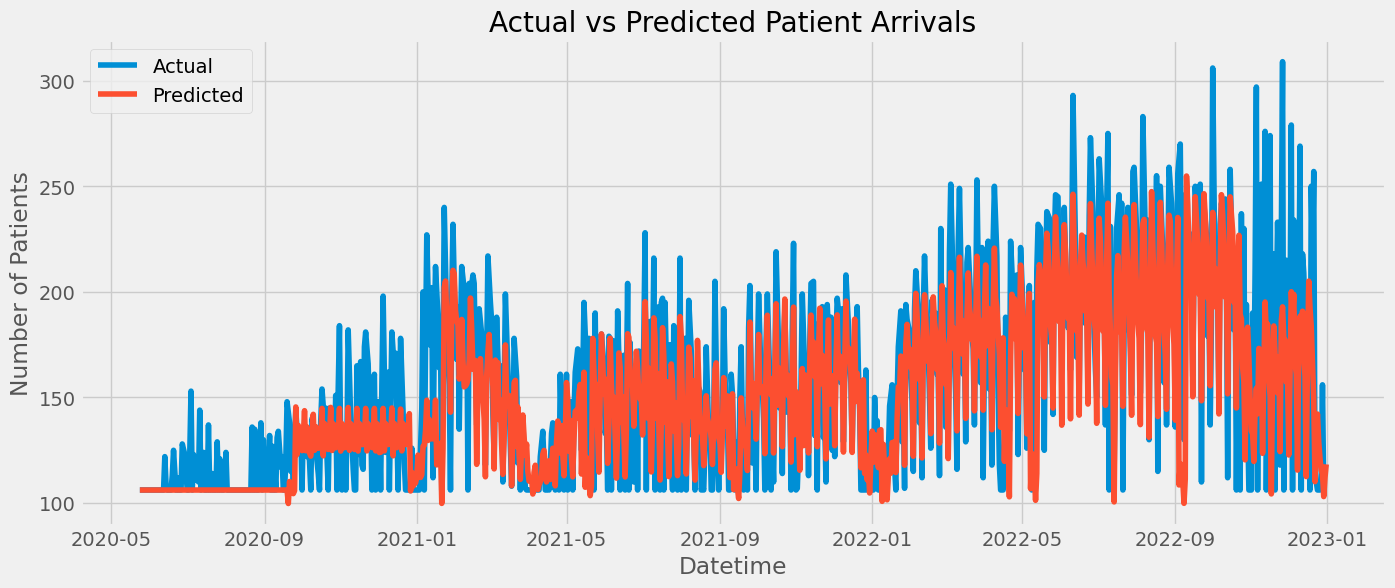

In [38]:
plt.figure(figsize=(15, 6))
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual')
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Predicted'], label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('Number of Patients')
plt.title('Actual vs Predicted Patient Arrivals')
plt.legend()
plt.show()

## Predicting the future

In [39]:
# Retrain on all data
df = create_features(df)

FEATURES = ['day_of_year', 'day_of_week', 'month', 'rolling_min', 'rolling_max',
            'rolling_sum', 'rolling_quantile_25', 'rolling_quantile_50', 'rolling_quantile_75', 
            'rolling_mean', 'rolling_median', 'rolling_std', 'lag1', 'lag2', 'lag3']


TARGET = 'Patients'

X_all = df[FEATURES]
y_all = df[TARGET]
    

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=900, 
                       early_stopping_rounds=50, 
                       tree_method='hist',
                       objective='reg:squarederror', 
                       max_depth=3, 
                       min_child_weight=3, 
                       gamma=0, 
                       learning_rate=0.01, 
                       colsample_bytree=0.9, 
                       subsample=0.7,
                       reg_lambda=0)
    
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)],
       verbose=100)

[0]	validation_0-rmse:163.01417
[100]	validation_0-rmse:64.58775
[200]	validation_0-rmse:32.05369
[300]	validation_0-rmse:22.76550
[400]	validation_0-rmse:19.77340
[500]	validation_0-rmse:18.21945
[600]	validation_0-rmse:17.31558
[700]	validation_0-rmse:16.58560
[800]	validation_0-rmse:16.00005
[899]	validation_0-rmse:15.45989


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
df.index.max()

Timestamp('2022-12-31 00:00:00')

In [41]:
# Create future DataFrame
future = pd.date_range('2022-12-31', '2023-06-28', freq='D')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [42]:
future_with_features = df_and_future.query('isFuture').copy()

In [44]:
future_with_features.tail()

Patients       date  day_of_week  month  day_of_year  rolling_min  \
2023-06-24       NaN 2023-06-24            5      6          175          NaN   
2023-06-25       NaN 2023-06-25            6      6          176          NaN   
2023-06-26       NaN 2023-06-26            0      6          177          NaN   
2023-06-27       NaN 2023-06-27            1      6          178          NaN   
2023-06-28       NaN 2023-06-28            2      6          179          NaN   

            rolling_max  rolling_sum  rolling_mean  rolling_median  \
2023-06-24          NaN          NaN           NaN             NaN   
2023-06-25          NaN          NaN           NaN             NaN   
2023-06-26          NaN          NaN           NaN             NaN   
2023-06-27          NaN          NaN           NaN             NaN   
2023-06-28          NaN          NaN           NaN             NaN   

            rolling_std  rolling_quantile_25  rolling_quantile_50  \
2023-06-24          NaN                  NaN                  NaN   
2023-06-25          NaN                  NaN                  NaN   
2023-06-26          NaN                  NaN                  NaN   
2023-06-27          NaN                  NaN                  NaN   
2023-06-28          NaN                  NaN                  NaN   

            rolling_quantile_75  lag1  lag2   lag3  isFuture  
2023-06-24                  NaN   NaN   NaN  106.2      True  
2023-06-25                  NaN   NaN   NaN  114.0      True  
2023-06-26                  NaN   NaN   NaN  156.0      True  
2023-06-27                  NaN   NaN   NaN  106.2      True  
2023-06-28                  NaN   NaN   NaN  106.2      True

## Feature Importance

In [45]:
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
feature_importance

importance
day_of_year            0.012376
day_of_week            0.047853
month                  0.005075
rolling_min            0.021270
rolling_max            0.030672
rolling_sum            0.182612
rolling_quantile_25    0.057758
rolling_quantile_50    0.115740
rolling_quantile_75    0.037592
rolling_mean           0.173596
rolling_median         0.249620
rolling_std            0.015160
lag1                   0.019649
lag2                   0.014102
lag3                   0.016924

<Axes: title={'center': 'Feature Importance'}>

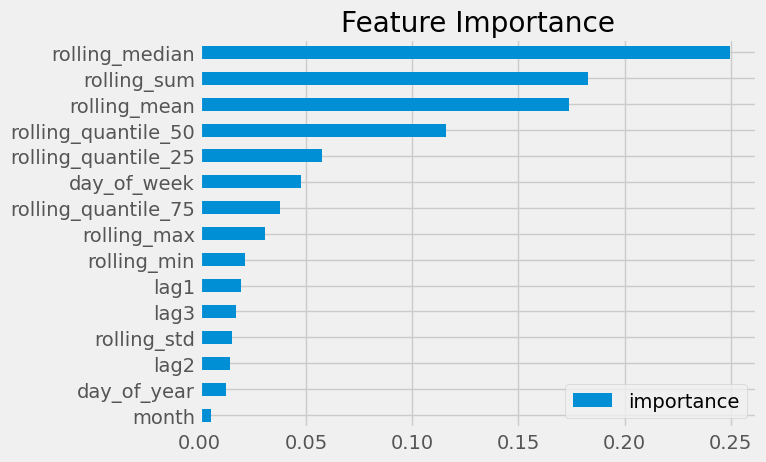

In [46]:
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')

## Predict the future

In [47]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])

In [48]:
future_with_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2022-12-31 to 2023-06-28
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Patients             0 non-null      float64       
 1   date                 180 non-null    datetime64[ns]
 2   day_of_week          180 non-null    int32         
 3   month                180 non-null    int32         
 4   day_of_year          180 non-null    int32         
 5   rolling_min          0 non-null      float64       
 6   rolling_max          0 non-null      float64       
 7   rolling_sum          0 non-null      float64       
 8   rolling_mean         0 non-null      float64       
 9   rolling_median       0 non-null      float64       
 10  rolling_std          0 non-null      float64       
 11  rolling_quantile_25  0 non-null      float64       
 12  rolling_quantile_50  0 non-null      float64       
 13  rolling_quantile

In [49]:
future_with_features.describe()

Patients                 date  day_of_week       month  day_of_year  \
count       0.0                  180   180.000000  180.000000   180.000000   
mean        NaN  2023-03-30 12:00:00     2.994444    3.527778    91.527778   
min         NaN  2022-12-31 00:00:00     0.000000    1.000000     1.000000   
25%         NaN  2023-02-13 18:00:00     1.000000    2.000000    45.750000   
50%         NaN  2023-03-30 12:00:00     3.000000    3.500000    90.500000   
75%         NaN  2023-05-14 06:00:00     5.000000    5.000000   135.250000   
max         NaN  2023-06-28 00:00:00     6.000000   12.000000   365.000000   
std         NaN                  NaN     2.015297    1.813760    55.589018   

       rolling_min  rolling_max  rolling_sum  rolling_mean  rolling_median  \
count          0.0          0.0          0.0           0.0             0.0   
mean           NaN          NaN          NaN           NaN             NaN   
min            NaN          NaN          NaN           NaN             NaN   
25%            NaN          NaN          NaN           NaN             NaN   
50%            NaN          NaN          NaN           NaN             NaN   
75%            NaN          NaN          NaN           NaN             NaN   
max            NaN          NaN          NaN           NaN             NaN   
std            NaN          NaN          NaN           NaN             NaN   

       rolling_std  rolling_quantile_25  rolling_quantile_50  \
count          0.0                  0.0                  0.0   
mean           NaN                  NaN                  NaN   
min            NaN                  NaN                  NaN   
25%            NaN                  NaN                  NaN   
50%            NaN                  NaN                  NaN   
75%            NaN                  NaN                  NaN   
max            NaN                  NaN                  NaN   
std            NaN                  NaN                  NaN   

       rolling_quantile_75        lag1        lag2        lag3        pred  
count                  0.0   30.000000   90.000000  180.000000  180.000000  
mean                   NaN  167.186667  183.321111  196.937778  108.433136  
min                    NaN  106.200000  106.200000  106.200000   73.787704  
25%                    NaN  107.150000  119.500000  155.000000   98.255907  
50%                    NaN  164.000000  195.500000  209.500000  112.768646  
75%                    NaN  209.750000  219.500000  234.125000  116.637087  
max                    NaN  279.000000  309.000000  309.000000  144.860397  
std                    NaN   57.473855   56.415050   52.049904   13.432329

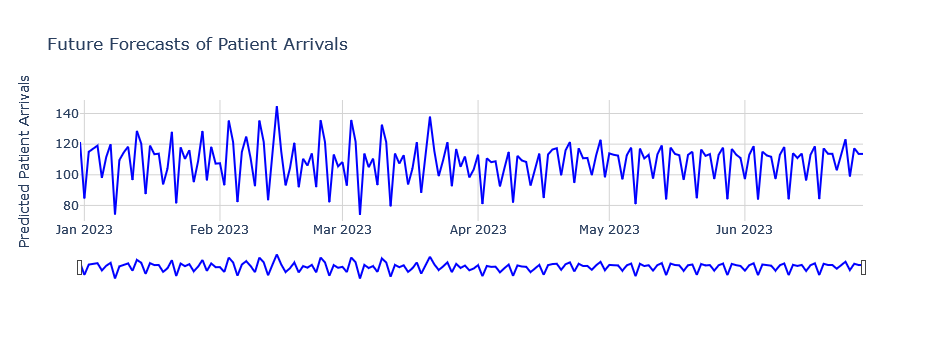

In [52]:
# Create a new figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=future_with_features.index, y=future_with_features['pred'],
                         name='Predicted Patient Arrivals',
                         line=dict(color='blue', width=2),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Patients</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))

fig.update_layout(
    title='Future Forecasts of Patient Arrivals',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Predicted Patient Arrivals',
    template='plotly_white'
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()

## Save the model

In [53]:
# Save the model
reg.save_model('forecast-models/xgboost_model_2.json')